# Data Modeling - Echo Chamber

## Local Code Imports - Do not delete

In [25]:
# DO NOT REMOVE THESE
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
# DO NOT REMOVE This
%reload_ext autoreload

In [27]:
## Uncomment to filter warnings
#import warnings
#warnings.filterwarnings('ignore')

In [30]:
## DO NOT REMOVE
## import local src module -
## src in this project will contain all your local code
## clean_data.py, model.py, visualize.py, custom.py
from src import make_data as mk
from src import visualize as viz
from src import model as mdl
from src import pandas_operators as po

def test_src():
    mk.test_make_data()
    viz.test_viz()
    mdl.test_model()
    po.test_pandas()
    
    return 1

In [ ]:
test_src()

## Code Imports

In [10]:
## Some standard imports
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from joblib import dump
import matplotlib.pyplot as plt
import seaborn as sns

# PySpark in AWS

Amazon Web Services (AWS) Elastic MapReduce (EMR) was utilized to process the MovieLens dataset. A cluster with the following configuration was used:
    Master Node: m3.xlarge instance 
    Core Nodes: five r3.2xlarge instances.
Using this cluster and PySpark's ML package, an ALS model was fit to the processed data (see the clean_drm_ec notebook for information on the data cleaning process).  User and item factors were extracted from this model and saved as a series of csv files.  These files were then imported into a local python notebook and converted into a single file for each type of factors (i.e., user and item). The single files were then unstacked. Both the stacked and unstacked files were then saved (see the AWS_data notebook for information on this process). 

Using the EMR cluster, the user factors were grouped into clusters using the KMeans algorithm in the PySpark ML package. KMeans models were constructed for k=2 to k=60 and the corresponding sum of squared distances to the nearest cluster were recorded. Code for the PySpark implementation of the ALS and KMeans models on AWS can be found in SparkALS.py located in the models folder. 

# PySpark Kmeans Evaluation

To identify the optimal number of clusters from the KMeans analysis (see above), the following code cells generate plots comparing the sum of squared distances (cost) to the number of clusters identified and comparing the change in cost to the number of clusters.  The errors were copied from the output of the PySpark implementation of the KMeans algorithm. 

In [6]:
error = [8113978.666767631, 7354872.282449911, 6779693.947846839, 6494419.943265818, 6161394.18380805, 5969178.495847053, 5775171.418613084, 5586181.465087898, 5459016.548945165, 5320932.3011912545, 5191293.46220535, 5090035.762150701, 4986521.909023397, 4919589.194313965, 4845781.722909153, 4738299.132215889, 4697877.381008717, 4626969.254411039, 4562072.290577676, 4519194.064635965, 4451951.002486911, 4413293.651221422, 4361910.62076177, 4339251.383448499, 4277987.088258287, 4244595.896973764, 4199613.235502976, 4156505.1574725825, 4131992.707043184, 4095312.234922758, 4069049.097594653, 4033434.5349058285, 4011851.7686528624, 3976083.217075855, 3949592.2147446494, 3938039.9457209697, 3899577.4734264542, 3881519.333619226, 3850186.2378393123, 3823198.4054184584, 3808773.2587171667, 3784495.988544207, 3761565.3901316617, 3746975.2839278127, 3723729.6121418993, 3699745.0362992603, 3680091.71095213, 3667951.1618961715, 3653602.1354131224, 3632124.2721405267, 3608965.8957424895, 3593001.8085261723, 3577712.029614562, 3560315.3167280406, 3552552.115932628, 3532308.4953923486, 3511941.7114949734, 3498429.793736455]

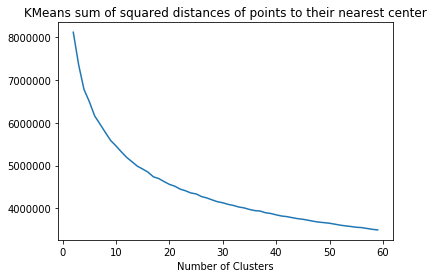

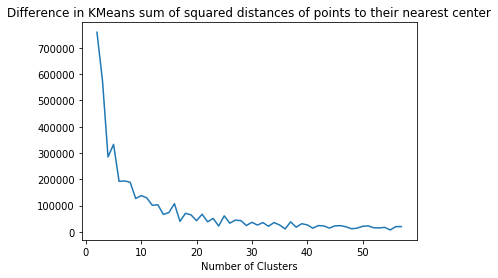

In [31]:
mdl.Spark_KMeans_Eval(error)

Based on the above plots, it was determined that nine clusters were optimal for this dataset. 

# KMeans

With the optimal number of clusters identified, a KMeans model with nine clusters was run and the cluster centroids saved (see code below). The cluster predictions were assigned to the object 'preds' for use in the Gradient Boosting Machine classification below.

In [ ]:
user_factors_scaled = pd.read_csv('../data/processed/user_factors_scaled.csv')
kmeans = KMeans(n_clusters = 9)
kmeans.fit(user_factors_scaled)

In [ ]:
preds = kmeans.predict(user_factors_scaled)
centroids = kmeans.cluster_centers_ 
centroids_df = pd.DataFrame(centroids)
centroids_df.to_csv('../data/processed/centroids.csv')

# Gradient Boosting Machine

In order to classify new users into clusters (which will be used to generate recommendations), a model for predicting the KMeans cluster was created. The gradient boosting machine specified below was able to correctly classify 95% of the test group. This model was saved for use in the final prediction function. 

In [ ]:
preds_df = pd.DataFrame(preds, columns=['cluster'])
user_factors_with_preds = user_factors.copy()
user_factors_with_preds['cluster'] = preds_df
X = user_factors_with_preds.drop(['id', 'cluster'], axis=1)
y = preds
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=142, shuffle=True)

In [ ]:
gbc = GradientBoostingClassifier()
param_grid = {'learning_rate':[.15], 
             'max_depth': [10],
             'min_samples_split': [25],
             'n_estimators': [42],
             'max_features': [7]}
gs_gbc = GridSearchCV(gbc, param_grid, cv=5)
gs_gbc.fit(X_train, y_train)
gbc_train_preds = gs_gbc.predict(X_train)
gbc_test_preds = gs_gbc.predict(X_test)
accuracy_score(y_test, gbc_test_preds), accuracy_score(y_train, gbc_train_preds)

In [ ]:
print(confusion_matrix(y_test, gbc_test_preds))
print(confusion_matrix(y_train, gbc_train_preds))

In [ ]:
dump(gs_gbc, '../models/fifp_classification.joblib') 

# Cluster Distances

The final step in the modeling process was to calculate the distances between clusters.  The distances are used in the recommendation function to identify the two clusters nearest to the new user's cluster and then return weighted recommendations from these clusters. 

In [ ]:
cluster_distances = cm.cluster_distances(centroids)
cluster_distances.to_csv('../data/processed/cluster_distances_df.csv')